# Cats vs Dogs

### 1. Introduction & Objectives

In this project, we will build a Convolutional Neural Network (CNN) to classify images of cats and dogs. The goal is to develop a model that can accurately differentiate between these two types of animals. The dataset we will be using contains 25,000 images in total, with 12,500 images of cats and 12,500 images of dogs. We will preprocess and divide the images into training, validation, and test sets to ensure robust model performance.

We will use Keras, with Tensorflow as the backend, to implement and train the CNN. After training, we will evaluate the model’s performance using separate test data to measure its ability to generalize to unseen images.

### 2. Data Understanding

The dataset consists of 25,000 images, with an equal split between cats and dogs (12,500 images of each). To facilitate model training and evaluation, we will use the following subsets:

    Training set: 1,000 images of cats and 1,000 images of dogs.
    Validation set: 500 images of cats and 500 images of dogs.
    Test set: 1,000 images of cats and 1,000 images of dogs.



We will use a Python script to create these subsets from the original dataset, as shown below:

In [ ]:
import os
import pathlib
import shutil

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Ensures TensorFlow only uses one GPU
os.environ["TF_ENABLE_NUMA_SUPPORT"] = "0"

original_dir = pathlib.Path("../Inputs/dogs_vs_cats_orig/train")
new_base_dir = pathlib.Path("../Inputs/cats_vs_dogs_data")

# Remove the new_base_dir if it already exists to avoid duplication
if new_base_dir.exists():
    shutil.rmtree(new_base_dir)


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directories
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)


# Create the subsets
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

This ensures the dataset is structured for training, validation, and testing phases, with a balanced distribution of cat and dog images in each subset.

#### 2.1 Importing Required Libraries and Loading the Data

We will begin by importing the necessary libraries, including TensorFlow, Keras layers, and utilities such as `image_dataset_from_directory`. After importing, we will set the `KERAS_BACKEND` to TensorFlow to ensure Keras operates on the correct backend. The training, validation, and test datasets will be loaded from their respective directories using the `image_dataset_from_directory` function. Each image will be resized to 180x180 pixels and organized into batches of 32, making the data ready for processing during model training, validation, and evaluation.

In [2]:
from keras import layers, Input, Model
from keras.src.utils import image_dataset_from_directory
from keras import callbacks
import keras
import matplotlib.pyplot as plt

In [3]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

train_dataset = image_dataset_from_directory(new_base_dir / 'train', image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / 'validation', image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / 'test', image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The data has been successfully loaded from the specified directories, with each image resized to 180x180 pixels and packed into batches of 32. Both the training and validation datasets are prepared, along with a test dataset for evaluation. We are now ready to proceed with building and training the image classification model.

### 3. Creating the model

We will build a Convolutional Neural Network (CNN) model using Keras to classify images of cats and dogs. The model begins with an input layer for images of shape (180, 180, 3). These input images will be rescaled by dividing pixel values by 255. The model will contain five convolutional layers, starting with 32 filters, followed by layers with 64, 128, and two consecutive layers with 256 filters, all using a 3x3 kernel size and ReLU activation. Each convolutional layer is followed by a max-pooling layer to downsample the feature maps. After the final convolutional layer, the feature maps are flattened into a 1D vector, followed by a dense layer with a single neuron and a sigmoid activation function to predict the probability of the image being a dog.

In [4]:
inputs = Input(shape=(180, 180, 3))

x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

The CNN model has been successfully constructed with five convolutional layers, followed by max-pooling layers to progressively downsample the feature maps. The convolutional layers increase in filter size from 32 to 256, enabling the model to capture a range of features at different scales. The feature maps are flattened after the final convolutional block, and a dense layer with a sigmoid activation function outputs the probability of the image being classified as a dog.

The model summary shows that it has 991,041 trainable parameters. The input layer processes images of size (180, 180, 3), and the max-pooling layers progressively reduce the spatial dimensions. The final dense layer outputs a single value, suitable for binary classification. With the architecture verified, we can now proceed to compile and fit the model to the training data for the cat vs. dog image classification task.

### 4. Compiling and Training the Model

We will compile the CNN model using the `Adam` optimizer and the binary cross-entropy loss function, which is appropriate for binary classification tasks. The model's performance will be measured using accuracy as the primary metric. During training, we will save the model's best version based on the validation loss using a `ModelCheckpoint` callback. The model will be trained for 30 epochs using the `fit` method, with training performed on the training dataset and validation on the validation dataset.

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    callbacks.ModelCheckpoint(
        filepath="../Models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5509 - loss: 0.7097

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.5231 - loss: 0.6987 - val_accuracy: 0.5460 - val_loss: 0.6911
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5234 - loss: 0.6904 - val_accuracy: 0.5780 - val_loss: 0.6665
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5673 - loss: 0.6705 - val_accuracy: 0.6730 - val_loss: 0.6093
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6242 - loss: 0.6497 - val_accuracy: 0.6570 - val_loss: 0.6149
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6798 - loss: 0.6111 - val_accuracy: 0.6230 - val_loss: 0.6452
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6939 - loss: 0.5848 - val_accuracy: 0.6940 - val_loss: 0.5892
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7088 - loss: 0.5549 - val_accuracy: 0.6990 - val_loss: 0.6119
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7592 - loss: 0.5083 - val_accuracy: 0.7200 - val_loss: 

The model was successfully compiled with the Adam optimizer and binary cross-entropy loss and trained for 30 epochs on the training dataset, with validation performed at each epoch. The training logs show a progressive improvement in accuracy, starting from 52.3% in the first epoch and reaching 100% accuracy by epoch 30. However, the validation accuracy started at 54.6% and improved to 70.7% by the final epoch, while the validation loss began to increase after several epochs.

In the early epochs, the model's loss and accuracy improved for both training and validation data, reaching a validation accuracy of 72% by epoch 8. However, after this point, the validation loss began to rise, and the validation accuracy plateaued, indicating potential overfitting. By the final epoch, the validation loss reached 2.3557, despite the model achieving perfect training accuracy.

Despite the overfitting observed in later epochs, the model's best performance on the validation dataset was saved using the `ModelCheckpoint` callback. We are now ready to evaluate the model's performance on the test dataset to assess its generalization capability on unseen data.

#### 4.1 Plotting Training and Validation Performance

We will create side-by-side plots to visualize the training and validation accuracy as well as the training and validation loss over the course of the training epochs. These plots help illustrate the model's learning process and allow us to monitor for potential issues such as overfitting or underfitting. By comparing both accuracy and loss in this way, we can better understand how the model's performance evolves during training and validation.

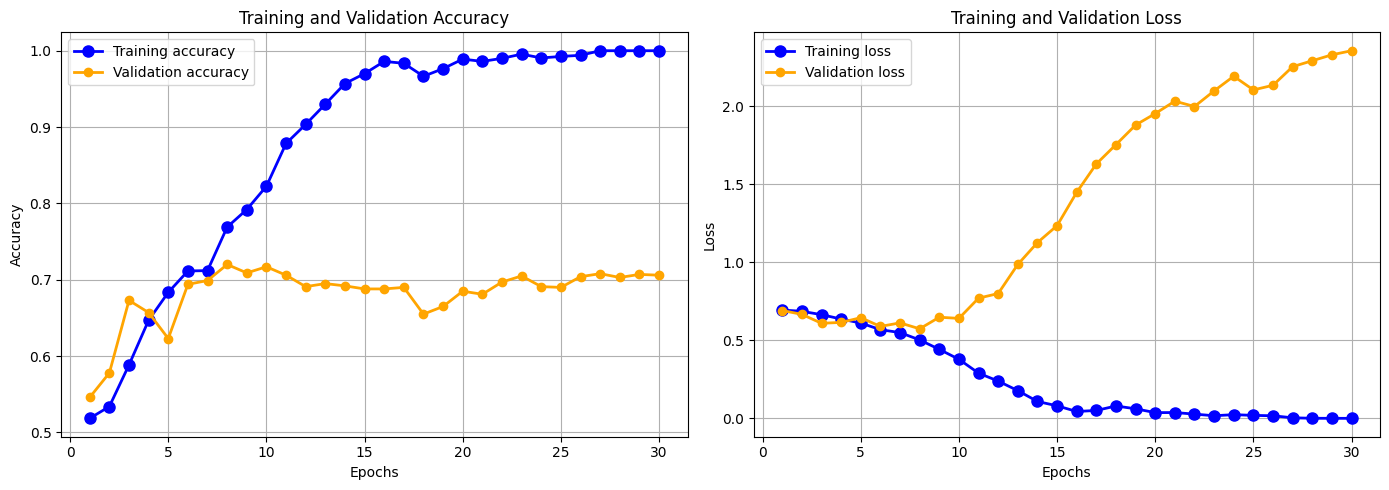

In [6]:
# Extracting data from history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy on the first subplot (left) with blue and orange colors
ax1.plot(epochs, accuracy, marker="o", linestyle="-", label="Training accuracy", markersize=8, linewidth=2, color="blue")
ax1.plot(epochs, val_accuracy, marker="o", linestyle="-", label="Validation accuracy", linewidth=2, color="orange")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Plot loss on the second subplot (right) with blue and orange colors
ax2.plot(epochs, loss, marker="o", linestyle="-", label="Training loss", markersize=8, linewidth=2, color="blue")
ax2.plot(epochs, val_loss, marker="o", linestyle="-", label="Validation loss", linewidth=2, color="orange")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


From the plots, we observe that the training accuracy steadily increases over the epochs, reaching perfect accuracy by epoch 15, while the validation accuracy plateaus at around 70% after epoch 8. The training loss continues to decrease as expected, but the validation loss begins to increase significantly after epoch 10. This indicates that the model starts to overfit to the training data, performing well on the training set but struggling to generalize to the validation data.

The sharp rise in validation loss while validation accuracy remains stagnant suggests that the model is overfitting. Regularization techniques such as dropout or early stopping may be necessary to prevent the model from memorizing the training data and improve generalization on unseen data

### 5. Evaluating the Model

We will evaluate the model's performance on the test dataset by loading the best saved version of the model and calculating its accuracy on unseen data. Using the evaluate method, the model will generate predictions for the test dataset, and we will measure both the test loss and test accuracy. The test accuracy provides an indication of how well the model generalizes to new, unseen images.

In [7]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7080 - loss: 0.5897
Test accuracy: 0.698


The model was evaluated on the test dataset, achieving a test accuracy of 69.8%. This result indicates that the model generalizes to unseen images reasonably well, although there is still room for improvement. Further tuning or the use of regularization techniques could help to enhance performance and reduce overfitting, as indicated by the increasing validation loss during training.

### 6. Improving the Model with Data Augmentation and Regularization

To address the overfitting observed in the initial model, we will introduce data augmentation and dropout regularization. Data augmentation helps to increase the diversity of the training data by applying random transformations to the images, such as rotation, zoom, and flip. This technique can help the model generalize better to unseen images and reduce overfitting.

#### 6.1 Data Augmentation and Regularization

We will create a new data augmentation layer using Keras' `Sequential` API. This layer will apply random transformations to the training images, including horizontal flipping, rotation, and zoom. These transformations will increase the diversity of the training data, which helps improve the model's generalization capability. Additionally, we will introduce dropout regularization by adding a dropout layer after the convolutional layers. Dropout randomly sets a fraction of input units to zero during training, which helps reduce overfitting by preventing the model from becoming too reliant on specific features.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

The data augmentation layer has been successfully created using Keras' `Sequential` API, incorporating random horizontal flipping, rotation (0.1 radians), and zoom (up to 20%) transformations. We will now integrate this layer into the model before training to enhance the model's generalization ability and mitigate overfitting.

#### 6.2 Training the Improved Model

We will train the improved model with data augmentation and dropout regularization, using a similar architecture to the previous model. The data augmentation layer will apply random transformations (horizontal flipping, rotation, and zoom) to the training images before they are passed into the model, increasing the diversity of the dataset. Dropout regularization will be introduced after the convolutional layers, with a dropout rate of 0.5, to help prevent overfitting and improve generalization.

In [9]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

The improved model has been successfully constructed with data augmentation and dropout regularization. The data augmentation layer enhances the diversity of the training images, while dropout regularization helps prevent overfitting by randomly deactivating 50% of the neurons during training. We are now ready to compile and train the improved model using the same training and validation datasets as before.

#### 6.3 Compiling and Training the Improved Model

We will compile the improved model using the RMSprop optimizer and binary cross-entropy loss, as it is suitable for binary classification tasks. The model will be trained for 100 epochs on the training dataset, with validation performed at each epoch. The `ModelCheckpoint` callback will save the best version of the model based on the validation loss. By incorporating data augmentation and dropout regularization, we aim to improve the model's ability to generalize and reduce overfitting.

In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../Models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4583 - loss: 0.7099

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5046 - loss: 0.6968

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5045 - loss: 0.6968

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5043 - loss: 0.6968 - val_accuracy: 0.5380 - val_loss: 0.6925
Epoch 2/100


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5688 - loss: 0.6863 - val_accuracy: 0.6140 - val_loss: 0.6579
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5597 - loss: 0.6876 - val_accuracy: 0.5160 - val_loss: 0.6880
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5571 - loss: 0.6772 - val_accuracy: 0.5700 - val_loss: 0.6720
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5852 - loss: 0.6713 - val_accuracy: 0.6440 - val_loss: 0.6402
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6496 - loss: 0.6292 - val_accuracy: 0.6170 - val_loss: 0.6487
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6285 - loss: 0.6341 - val_accuracy: 0.6850 - val_loss: 0.6007
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6853 - loss: 0.5944 - val_accuracy: 0.6620 - val_loss: 0.6194
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6746 - loss: 0.6043 - val_accuracy: 0.6980 - val_l

The improved model with data augmentation and dropout regularization was trained for 100 epochs. In the early epochs, the training accuracy started at 50.4%, with the validation accuracy at 53.8% and a validation loss of 0.6925. As the training progressed, the model’s performance steadily improved. By epoch 20, the model achieved a training accuracy of 77.2% and a validation accuracy of 77.2%, with a validation loss of 0.4752.

Throughout the training process, the model’s training accuracy continued to increase, reaching a high of 95.2% by epoch 100. The validation accuracy also steadily improved, peaking at 86.4%, though the validation loss fluctuated and ended at 0.4502. This indicates that while the model generalizes better than before, further optimization may be needed to reduce the validation loss.

The best version of the model, based on validation loss, was saved using the `ModelCheckpoint` callback, and we are now ready to evaluate its performance on the test dataset.

#### 6.4 Plotting Training and Validation Performance

We will generate side-by-side plots to visualize the training and validation accuracy, as well as the training and validation loss, throughout the training epochs of the improved model. These visualizations will allow us to track the model's learning progress and evaluate its generalization performance. By comparing the training and validation metrics, we can analyze the effectiveness of the data augmentation and dropout regularization in enhancing the model’s overall performance and reducing overfitting.

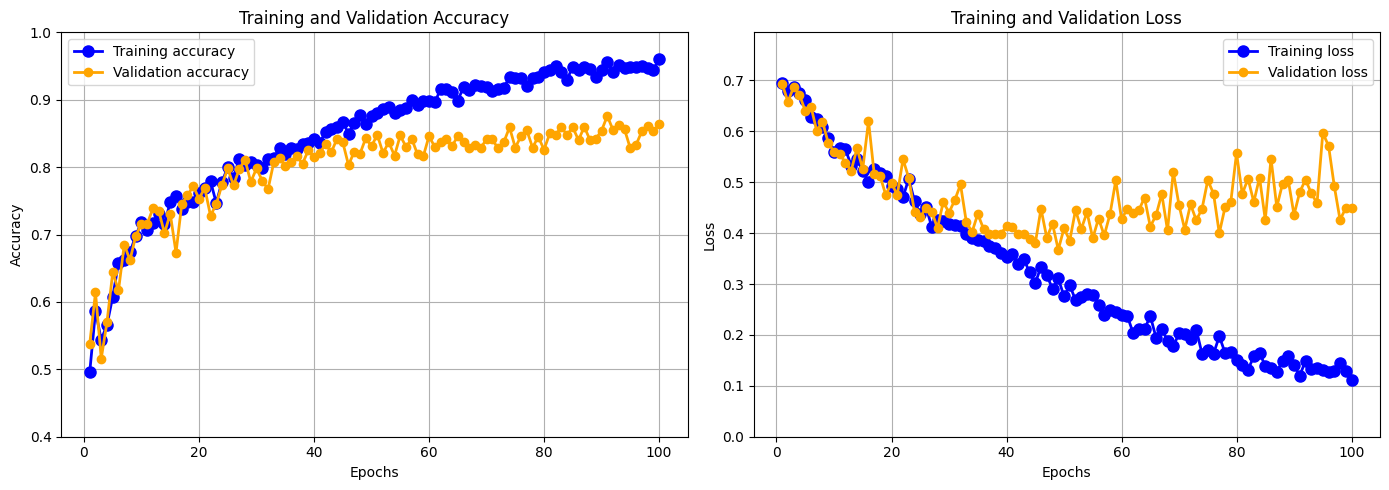

In [11]:
# Extracting data from the new model's history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy on the first subplot (left) with blue and orange colors
ax1.plot(epochs, accuracy, marker="o", linestyle="-", label="Training accuracy", markersize=8, linewidth=2, color="blue")
ax1.plot(epochs, val_accuracy, marker="o", linestyle="-", label="Validation accuracy", linewidth=2, color="orange")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0.4, 1.0])  # Set y-axis limits to better visualize the accuracy changes
ax1.legend()
ax1.grid(True)

# Plot loss on the second subplot (right) with blue and orange colors
ax2.plot(epochs, loss, marker="o", linestyle="-", label="Training loss", markersize=8, linewidth=2, color="blue")
ax2.plot(epochs, val_loss, marker="o", linestyle="-", label="Validation loss", linewidth=2, color="orange")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_ylim([0.0, max(max(loss), max(val_loss)) + 0.1])  # Set y-axis limits for better loss visualization
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


From the plots, we observe that the training accuracy steadily increases, reaching over 95%, while the validation accuracy stabilizes around 85-86% after epoch 80. The training loss consistently decreases, but the validation loss fluctuates, suggesting mild overfitting. Despite this, the validation accuracy remains stable, indicating that data augmentation and dropout have improved the model’s generalization and reduced severe overfitting.

#### 6.5 Evaluating the Improved Model

We will evaluate the performance of the improved model, which includes data augmentation and dropout regularization, on the test dataset. By loading the best saved version of the model, we will calculate the test loss and accuracy to determine how well the model generalizes to unseen images.

In [13]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8214 - loss: 0.4272
Test accuracy: 0.823


After evaluation, the model achieved a test accuracy of 82.3%, with a test loss of 0.4272. This result demonstrates that the model generalizes well to new data, maintaining strong performance on unseen images.

### 7. Conclusion

In this project, we developed a Convolutional Neural Network (CNN) to classify images of cats and dogs. We began by loading the dataset and dividing it into training, validation, and test sets. We then constructed a CNN model with five convolutional layers, followed by max-pooling layers and a dense layer for binary classification. The initial model achieved 69.8% accuracy on the test dataset but showed signs of overfitting. 

To address this, we introduced data augmentation and dropout regularization to enhance the model's generalization ability.

The improved model, trained with data augmentation and dropout, achieved a test accuracy of 82.3%, demonstrating better generalization to unseen images. By incorporating data augmentation and dropout regularization, we successfully reduced overfitting and improved the model's performance on the test dataset.

Overall, the project highlights the importance of data augmentation and regularization techniques in enhancing the performance and generalization of CNN models for image classification tasks. By leveraging these methods, we can build more robust models capable of accurately classifying images and achieving strong performance on unseen data.